In [53]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from jcamp import JCAMP_reader
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.interpolate import interp1d
from scipy.optimize import basinhopping
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score

sns.set(style='whitegrid')

# Задание 1

In [54]:
def interpolation(x_, y):
    global x
    f = interp1d(x_, y)
    return f(x)

In [55]:
database_dir = 'datasets/'

x = np.arange(600, 3601)

titles, I_list = [], []

for f in os.listdir(database_dir):
    x_orig = JCAMP_reader(database_dir + f).get('x')
    I_orig = JCAMP_reader(database_dir + f).get('y')
    I_orig = I_orig / np.max(I_orig)
    y_units = JCAMP_reader(database_dir + f).get('yunits')
    
    if y_units == 'ABSORBANCE':
        I_orig = np.exp( - I_orig)

    if np.min(I_orig) <= 0.2:
        I_orig = (1 - 0.8 / (1 - np.min(I_orig)) * (1 - I_orig))
        
    titles.append(JCAMP_reader(database_dir + f).get('title').lower())
    I_list.append(interpolation(x_orig, I_orig))

I_list.reverse()
titles.reverse()
spectra = pd.DataFrame(np.array(I_list).T, columns=titles)
spectra

,carbon dioxide,butane,hydrogen sulfide,ethanol,carbon disulfide,ethane,1-butanol,methanol,propane,ammonia
0,0.911814,0.997079,0.982000,0.972789,0.963648,0.987483,0.974003,0.979608,0.994790,0.989585
1,0.908458,0.996743,0.982000,0.972789,0.963964,0.985970,0.971850,0.979608,0.993916,0.990190
2,0.917003,0.997005,0.982406,0.972789,0.964105,0.986572,0.972604,0.979218,0.994157,0.991847
3,0.928974,0.997341,0.984000,0.973418,0.964192,0.987439,0.973722,0.977600,0.994538,0.995541
4,0.933753,0.997678,0.984000,0.973696,0.964298,0.988306,0.974840,0.974120,0.994918,0.995467
...,...,...,...,...,...,...,...,...,...,...
2996,0.716657,0.998861,0.881167,0.963691,0.967919,0.997473,0.994635,0.937194,0.998861,0.945596
2997,0.717928,0.998816,0.880740,0.963019,0.967919,0.997503,0.994769,0.937194,0.998921,0.945596
2998,0.720068,0.998861,0.879582,0.961621,0.967919,0.997503,0.994634,0.936727,0.998382,0.945596
2999,0.723816,0.998906,0.878770,0.961184,0.967884,0.997503,0.994500,0.935803,0.997843,0.945596


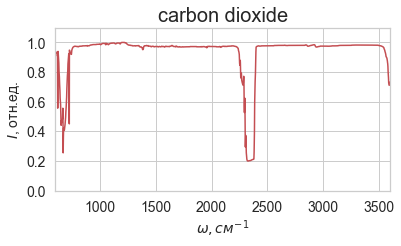

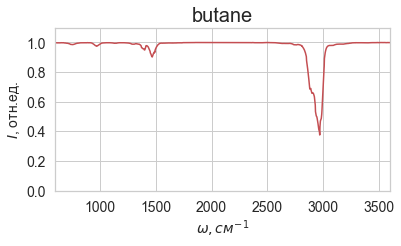

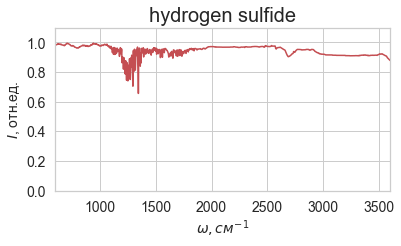

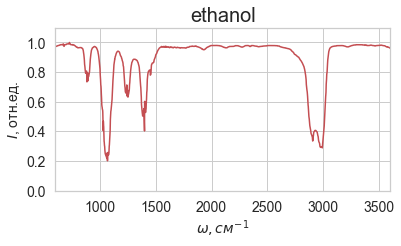

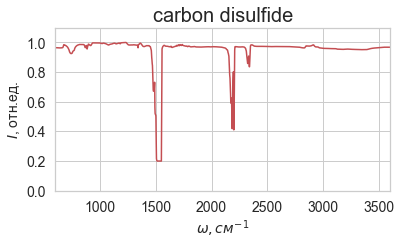

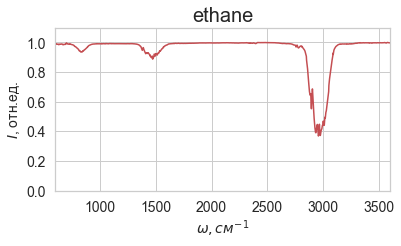

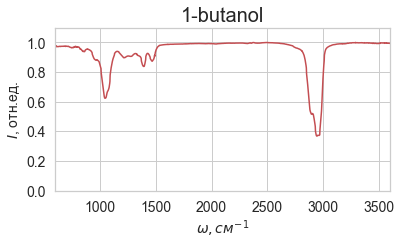

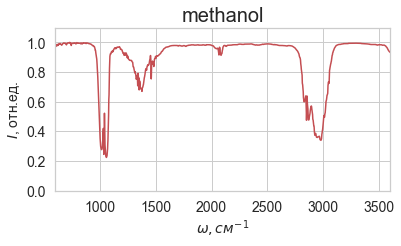

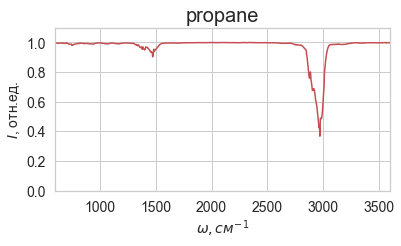

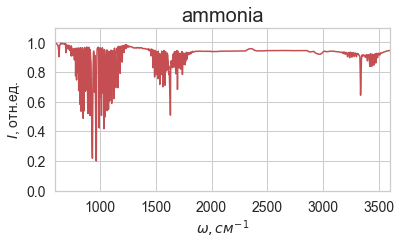

In [56]:
for i in range(len(titles)):
    plt.figure(figsize=(6, 3))
    plt.plot(x, spectra[titles[i]], lw = 1.5, c='r')
    plt.xlabel(r'$\omega,см^{-1}$', fontdict={'fontsize':14})
    plt.ylabel(r'$I$, отн.ед.', fontdict={'fontsize':14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(600, 3600)
    plt.ylim(0.0, 1.1)
    plt.grid(True)
    plt.title(titles[i], fontdict={'fontsize':20})
    plt.savefig(titles[i] + '.png', dpi=200, bbox_inches='tight')
    plt.show()

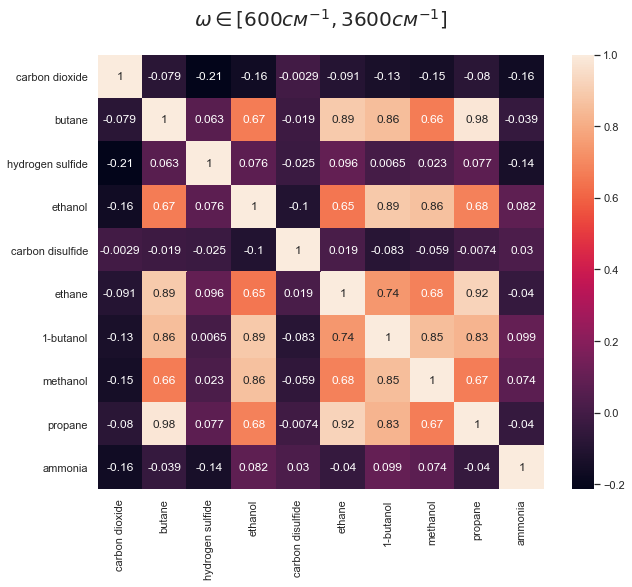

In [57]:
plt.figure(figsize=(10, 8))
corr = sns.heatmap(spectra.corr(), annot=True)
corr.set_title('$\omega\in[600 см^{-1},3600 см^{-1}]$\n', fontdict={'fontsize':20})
plt.savefig('corr_1.png', dpi=300, bbox_inches='tight')

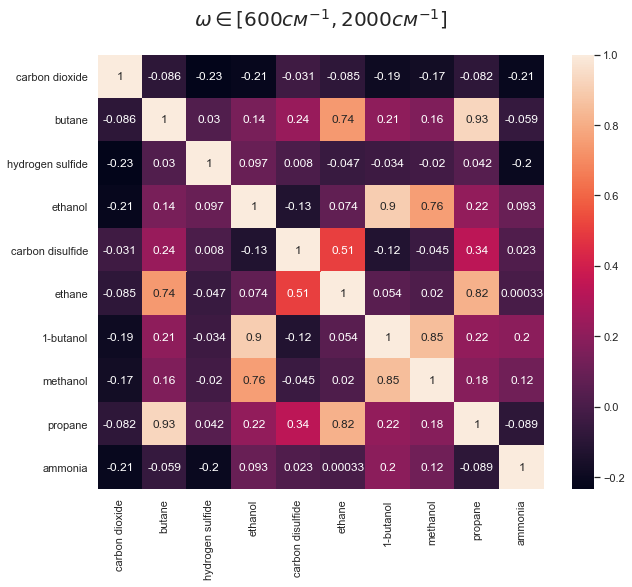

In [58]:
plt.figure(figsize=(10, 8))
corr = sns.heatmap(spectra.iloc[:1400].corr(), annot=True)
corr.set_title('$\omega\in[600 см^{-1}, 2000 см^{-1}]$\n', fontdict={'fontsize':20})
plt.savefig('corr_2.png', dpi=300, bbox_inches='tight')

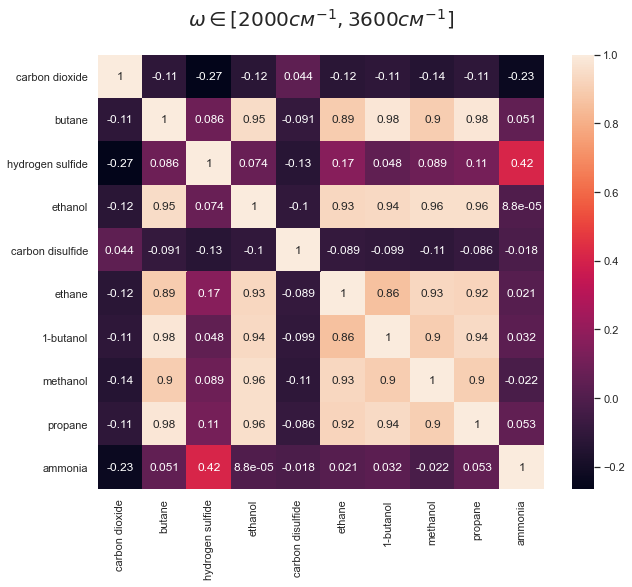

In [59]:
plt.figure(figsize=(10, 8))
corr = sns.heatmap(spectra.iloc[1400:].corr(), annot=True)
corr.set_title('$\omega\in[2000 см^{-1},3600 см^{-1}]$\n', fontdict={'fontsize':20})
plt.savefig('corr_3.png', dpi=300, bbox_inches='tight')

# Задание 2

In [60]:
def rel_err(x, x_true):
    return np.round(abs(x - x_true) / x_true * 100, 2)

class conc_estimator:
    def __init__(self, spectrum_to_explore, spectra_db, mode, c_init=0.5, c_orig=100):
        self.spectrum_to_explore = - np.log(spectrum_to_explore)
        self.spectra_db = - np.log(spectra_db)
        self.mode = mode
        self.c_init = c_init
        self.c_orig = c_orig
        self.c_est = None
        self.sub_est = None
        
    def func_to_minimize(self, c, c_orig=100):
        spectrum_db = self.spectrum_db * c / c_orig
        return sum(abs(self.spectrum_to_explore - spectrum_db) ** 2) / len(spectrum_db)
    
    def gradient_descent(self, h=1e-2, alpha=1e3, iterations=10000):
        c = self.c_init
        for i in range(iterations):
            if i % 100 == 0:
                alpha = alpha * 0.99
            grad = - 2 * self.spectrum_db.T.dot((self.spectrum_to_explore - self.spectrum_db * c / self.c_orig)) / self.c_orig / len(self.spectrum_db)
            c -= alpha * grad

        return c
    
    def bas(self):
        opt = basinhopping(self.func_to_minimize, x0=self.c_init, minimizer_kwargs={"method": "BFGS"}, niter=200)
        return opt.x
    
    def estimate(self):
        c_arr, corr_arr = np.zeros(self.spectra_db.shape[1]), np.zeros(self.spectra_db.shape[1])
        for i in range(self.spectra_db.shape[1]):
            self.spectrum_db = np.array(self.spectra_db[self.spectra_db.columns[i]])
            if self.mode == 'gd':
                c_arr[i] = self.gradient_descent()
            elif self.mode == 'bas':
                c_arr[i] = self.bas()
            corr_arr[i] = pearsonr(self.spectrum_to_explore, self.spectrum_db)[0]
        self.sub_est = self.spectra_db.columns[np.argmax(corr_arr)]
        self.c_est = c_arr[np.argmin(corr_arr)]
        return (self.sub_est, self.c_est)

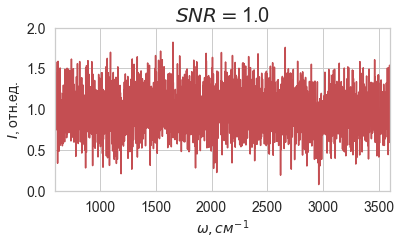

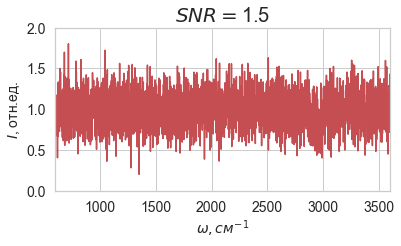

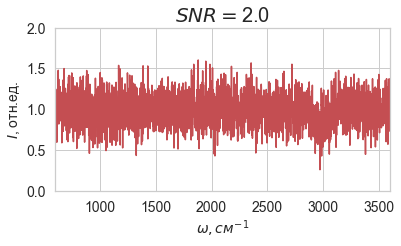

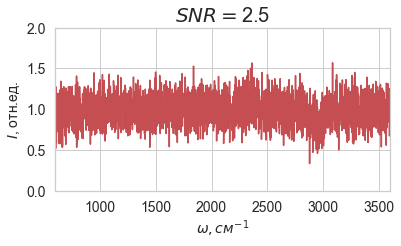

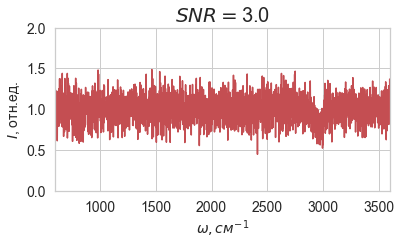

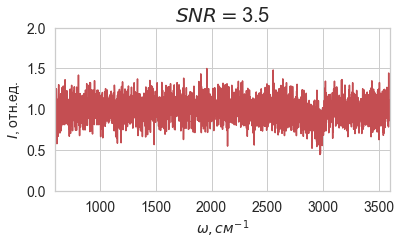

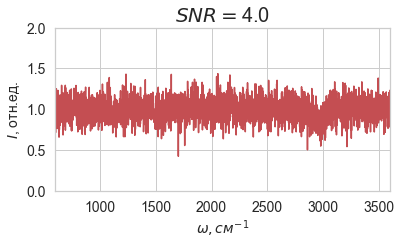

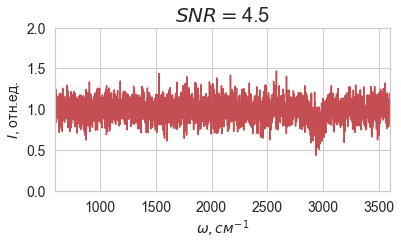

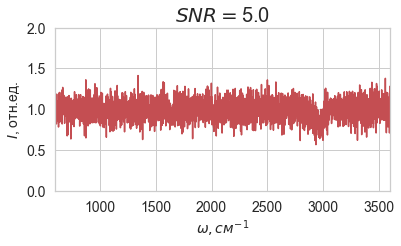

In [61]:
"""
в-во 9 (propane) 
"""
np.random.seed(0)
c_orig = 100
c_for_est = 30

spectrum = np.exp(np.log(np.array(spectra['propane'])) * c_for_est / c_orig)
noisy_spectra = []
SNR_list = np.arange(1.0, 5.5, 0.5)

for SNR in SNR_list:
    noise = [np.random.normal(0, (max(1 - spectrum) / (SNR ** 0.5))) for i in range(len(spectrum))]
    noisy_spectra.append(spectrum + noise)
    plt.figure(figsize=(6, 3))
    plt.plot(x, spectrum + noise, lw = 1.5, c='r')
    plt.xlabel(r'$\omega,см^{-1}$', fontdict={'fontsize':14})
    plt.ylabel(r'$I$, отн.ед.', fontdict={'fontsize':14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(600, 3600)
    plt.ylim(0, 2.0)
    plt.grid(True)
    plt.title('$SNR=$' + str(SNR), fontdict={'fontsize':20})
    plt.savefig('$SNR=$' + str(SNR) + '.png', dpi=200, bbox_inches='tight')
    plt.show()

In [62]:
spectrum = noisy_spectra[2]
gd_estimator = conc_estimator(spectrum, spectra, mode='gd')
bas_estimator = conc_estimator(spectrum, spectra, mode='bas')
results_gd = gd_estimator.estimate()
results_bas = bas_estimator.estimate()

In [63]:
print('Метод: Градиентный спуск',
    '\nВещество:', str(results_gd[0]),
      '\nПредсказанная концентрация:', str(np.round(results_gd[1], 3)),
      '\nОтносительная погрешность восстановления концентрации:', str(rel_err(results_gd[1], c_for_est)) + '%')

print('\nМетод: Отжиг',
    '\nВещество:', str(results_bas[0]), 
      '\nПредсказанная концентрация:', str(np.round(results_bas[1], 3)),
      '\nОтносительная погрешность восстановления концентрации:', str(rel_err(results_bas[1], c_for_est)) + '%')

Метод: Градиентный спуск 
Вещество: propane 
Предсказанная концентрация: 0.042 
Относительная погрешность восстановления концентрации: 99.86%

Метод: Отжиг 
Вещество: propane 
Предсказанная концентрация: 0.043 
Относительная погрешность восстановления концентрации: 99.86%


# Задание 3

In [93]:
def make_mix(spectra, ids, conc_true, c_orig, SNR):
    mix = 1
    for i in range(len(ids)):
        s = np.exp(np.log(spectra[spectra.columns[ids[i]]]) * conc_true[i] / c_orig)
        mix = mix * s
    noise = [np.random.normal(0, (max(1 - mix) / SNR ** 0.5)) for i in range(len(mix))]
    return mix + noise

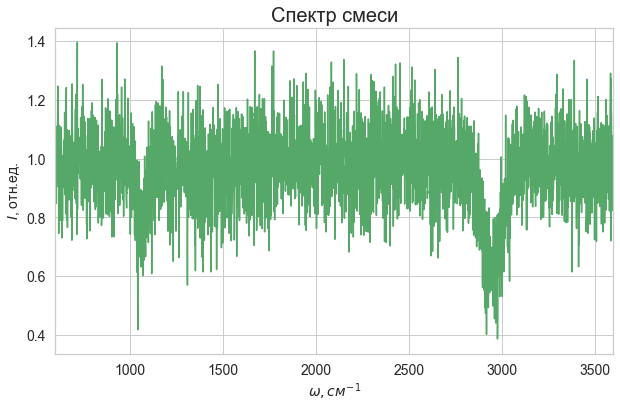

In [94]:
ids = [1, 3, 5]
conc_true = [10, 15, 20]

SNR = 10
mix = make_mix(spectra, ids, conc_true, c_orig, SNR)

plt.figure(figsize=(10, 6))
plt.plot(x, mix, lw = 1.5, c='g')
plt.xlabel(r'$\omega,см^{-1}$', fontdict={'fontsize':14})
plt.ylabel(r'$I$, отн.ед.', fontdict={'fontsize':14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(600, 3600)
# plt.ylim(0.0, 1.1)
plt.grid(True)
plt.title('Cпектр смеси', fontdict={'fontsize':20})
plt.savefig('mix.png', dpi=200, bbox_inches='tight')
plt.show()

In [95]:
mixed = np.array([np.log(spectra[spectra.columns[i]]) for i in ids]).T
conc = np.linalg.inv(mixed.T.dot(mixed)).dot(mixed.T).dot(np.log(mix)) * c_orig

for i in range(len(ids)):
    print('Относительная ошибка восстановления концентрации вещества', str(titles[ids[i]]),
          ':', str(rel_err(conc[i], conc_true[i])) + '%')

Относительная ошибка восстановления концентрации вещества butane : 41.25%
Относительная ошибка восстановления концентрации вещества ethanol : 14.7%
Относительная ошибка восстановления концентрации вещества ethane : 12.3%


# Задание 4

In [84]:
from tqdm.notebook import tqdm

class classifier():
    def __init__(self, spectra_db, mode='pearson'):
        self.spectra_db = spectra_db
        self.mode = mode
        self.spectrum_to_explore = None
        self.sub_est = None
        self.p = None
        self.knn_clf = None
        self.pca = None
        self.tsne = None
        self.rf = None
        self.titles = None
    
    def prepare(self):
        if self.mode == 'pca':
            noisy_spectra = self.spectra_db.copy().T
            noisy_spectra['substance'] = noisy_spectra.index
            noisy_spectra.reset_index(inplace=True, drop=True)
            self.titles = self.spectra_db.columns

            for i in tqdm(range(50)):
                for subst in self.titles:
                    spectrum, SNR = np.array(self.spectra_db[subst]), 3
                    amp = max(1 - spectrum)
                    noisy_spectra = noisy_spectra.append(pd.Series(np.array(noised(spectrum, SNR, amp))), ignore_index=True)
                    noisy_spectra.substance[noisy_spectra.shape[0] - 1] = subst
            X = noisy_spectra.iloc[10:].copy()
            X['substance'] = noisy_spectra['substance']
            X.reset_index(inplace=True, drop=True)
            X_rescaled = (X.drop(columns='substance'))
            self.pca = PCA(n_components=3)
            self.sc = StandardScaler()
            X_rescaled = self.sc.fit_transform(X_rescaled)
            self.pca.fit(X_rescaled)
            X_reduced = self.pca.transform(X_rescaled)
            self.spectra_db = X_reduced
            targets = list(np.arange(len(self.titles))) * 50
            self.knn_clf = KNeighborsClassifier(n_neighbors=100)
            self.knn_clf.fit(X_reduced, targets)

        elif self.mode == 'tsne':
            noisy_spectra = self.spectra_db.copy().T
            noisy_spectra['substance'] = noisy_spectra.index
            noisy_spectra.reset_index(inplace=True, drop=True)
            self.titles = self.spectra_db.columns
            for i in tqdm(range(50)):
                for subst in self.titles:
                    spectrum, SNR = np.array(self.spectra_db[subst]), 3
                    amp = max(1 - spectrum)
                    noisy_spectra = noisy_spectra.append(pd.Series(np.array(noised(spectrum, SNR, amp))), ignore_index=True)
                    noisy_spectra.substance[noisy_spectra.shape[0] - 1] = subst
            X = noisy_spectra.iloc[10:].copy()
            X['substance'] = noisy_spectra['substance']
            X.reset_index(inplace=True, drop=True)
            X_rescaled = (X.drop(columns='substance'))
            pca = PCA(n_components=3)
            pca.fit(X_rescaled)
            X_reduced = pca.transform(X_rescaled)
            
            self.tsne = TSNE(n_components=3, perplexity=15, learning_rate=10, init='pca', random_state=8)
            X_reduced = self.tsne.fit_transform(np.array(X_reduced))

            self.rf = RandomForestRegressor()
            self.rf.fit(X_rescaled, X_reduced)
            
            targets = list(np.arange(len(self.titles))) * 50
            self.knn_clf = KNeighborsClassifier(n_neighbors=100)
            self.knn_clf.fit(X_reduced, targets)
        else:
            X = self.spectra_db.copy().T
            X['substance'] = X.index
            self.titles = X.index
            targets = np.arange(len(titles))

    def corr(self, spectrum_db):
        return pearsonr(self.spectrum_to_explore, spectrum_db)[0]
        
    def predict(self, spectrum_to_explore, target, thr=0.0):
        self.spectrum_to_explore = np.array(spectrum_to_explore)
        
        if self.mode == 'pearson':
            corr_arr = []
            for i in range(self.spectra_db.shape[1]):
                self.spectrum_db = np.array(self.spectra_db[self.spectra_db.columns[i]])
                corr_arr.append(self.corr(self.spectrum_db))
            if max(corr_arr) >= thr:
                self.sub_est = self.spectra_db.columns[np.argmax(corr_arr)]
            else:
                self.sub_est = 'not estimated'
            self.p = corr_arr
            
        elif self.mode == 'pca':
            self.spectrum_to_explore = self.spectrum_to_explore.reshape(1, -1)
            self.spectrum_to_explore = self.sc.transform(self.spectrum_to_explore)
            self.spectrum_to_explore = self.pca.transform(self.spectrum_to_explore)
            self.p = self.knn_clf.predict_proba(self.spectrum_to_explore.reshape(1, -1))[0]
            if self.p[list(self.titles).index(target)] >= thr:
                self.sub_est = self.titles[self.knn_clf.predict(self.spectrum_to_explore)[0]]
            else:
                self.sub_est = 'not estimated'

        elif self.mode == 'tsne':
            self.spectrum_to_explore = self.spectrum_to_explore.reshape(1, -1)
            self.spectrum_to_explore = self.rf.predict(self.spectrum_to_explore).reshape(1, -1)
            self.p = self.knn_clf.predict_proba(self.spectrum_to_explore)[0]
            if self.p[list(self.titles).index(target)] >= thr:
                self.sub_est = self.titles[self.knn_clf.predict(self.spectrum_to_explore)[0]]
            else:
                self.sub_est = 'not estimated'
            self.p = self.knn_clf.predict_proba(self.spectrum_to_explore)[0]

            
        return (self.sub_est, self.p)

def classifier_test(subst, SNR):
    classifier_pearson = classifier(spectra, mode='pearson')
    classifier_pca = classifier(spectra, mode='pca')
    classifier_pca.prepare()
    classifier_tsne = classifier(spectra, mode='tsne')
    classifier_tsne.prepare()

    preds_pearson, preds_pca, preds_tsne = [], [], []

    spectrum = spectra[subst]
    amp = 1 - min(spectrum)
    thr_arr = np.arange(0, 1, 0.05)

    for thr in tqdm(thr_arr):
        #print(thr)
        preds_pearson_for_thr, preds_pca_for_thr, preds_tsne_for_thr = [], [], []
        for i in range(100):
            sp_to_exp = noised(spectrum, SNR, amp)
            preds_pearson_for_thr.append(classifier_pearson.predict(sp_to_exp, subst, thr)[0])
            preds_pca_for_thr.append(classifier_pca.predict(sp_to_exp, subst, thr)[0])
            preds_tsne_for_thr.append(classifier_tsne.predict(sp_to_exp, subst, thr)[0])
        preds_pearson.append(preds_pearson_for_thr)
        preds_pca.append(preds_pca_for_thr)
        preds_tsne.append(preds_tsne_for_thr)
    
    preds_pearson_stat = get_stats(preds_pearson, subst)
    preds_pca_stat = get_stats(preds_pca, subst)
    preds_tsne_stat = get_stats(preds_tsne, subst)

    plt.figure(figsize=(10, 6))
    plt.plot(thr_arr, preds_pca_stat, lw = 3, c='red', label='PCA')
    plt.plot(thr_arr, preds_pearson_stat, lw = 3, c='blue', label='Pearson')
    plt.plot(thr_arr, preds_tsne_stat, lw = 3, c='green', label='TSNE')
    plt.xlabel(r'Порог отсечки, отн.ед.', fontdict={'fontsize':14})
    plt.ylabel(r'$P$, отн.ед.', fontdict={'fontsize':14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.title('Доля верных обнаружений', fontdict={'fontsize':20})
    plt.savefig(subst + 'p50.png', dpi=200, bbox_inches='tight')
    plt.show()
    
        
    return (preds_pearson, preds_pca, preds_tsne)

def noised(spectrum, SNR, amp):
    noise = [np.random.normal(0, amp / (SNR ** 0.5)) for i in range(len(spectrum))]
    noised_spectra = spectrum + noise
    return noised_spectra

def get_stats(preds, subst):
    preds_stat = []
    for pred in preds:
        if pred.count('not estimated') != len(pred):
            preds_stat.append(pred.count(subst) / len(pred))
        else:
            preds_stat.append(0)
    return preds_stat

def closest(lst, K): 
    lst = np.asarray(lst) 
    idx = (np.abs(lst - K)).argmin() 
    return lst[idx] 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


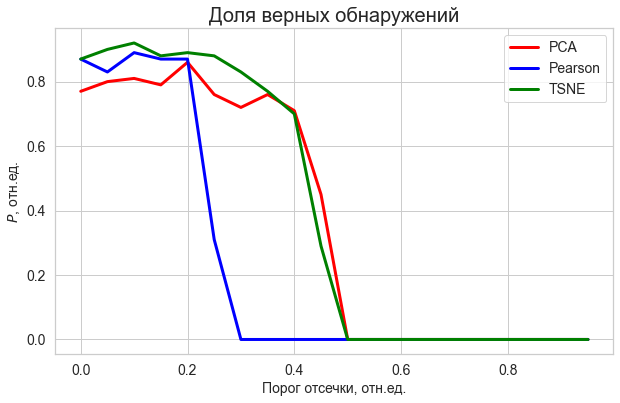

In [85]:
SNR = 3

subst_7 = 'butane'

preds_pearson_6, preds_pca_6, preds_tsne_6 = classifier_test(subst_7, SNR)

In [87]:
thr_arr = np.arange(0, 1, 0.05)
preds_pearson_6_stat = get_stats(preds_pearson_6, subst_7)
print('Порог отсечки для вероятности правильного обнаружения 50%:', thr_arr[preds_pearson_6_stat.index(closest(preds_pearson_6_stat, 0.5))])
preds_pca_6_stat = get_stats(preds_pca_6, subst_7)
print('Порог отсечки для вероятности правильного обнаружения 50%:', thr_arr[preds_pca_6_stat.index(closest(preds_pca_6_stat, 0.5))])
preds_tsne_6_stat = get_stats(preds_tsne_6, subst_7)
print('Порог отсечки для вероятности правильного обнаружения 50%:', thr_arr[preds_tsne_6_stat.index(closest(preds_tsne_6_stat, 0.5))])

Порог отсечки для вероятности правильного обнаружения 50%: 0.25
Порог отсечки для вероятности правильного обнаружения 50%: 0.45
Порог отсечки для вероятности правильного обнаружения 50%: 0.4


# Задание 5

In [88]:
def get_roc(clf, test_subst, SNR=3, N=3000):
    global spectra, titles, noised
    clf.prepare()
    y_true, y_score = [], []
    for i in tqdm(range(N)):
        sub = np.random.choice(titles)
        spectrum = spectra[sub]
        amp = 1 - min(spectrum)   
        spectrum = np.array(noised(spectrum, SNR, amp))
        pred_sub, p = clf.predict(spectrum, test_subst)
        if sub == test_subst:
            idx = 1
        else:
            idx = 0
        y_score.append(p[titles.index(test_subst)])
        y_true.append(idx)
    return (y_true, y_score)

def get_optim_thr(tpr, fpr):
    dist = [np.sqrt(fpr[i]) ** 2 + (tpr[i] - 1) ** 2 for i in range(len(tpr))]
    optimal_thr = np.round(dist[np.where(dist == min(dist))[0][0]], 3)
    return optimal_thr

In [89]:
clf_pearson = classifier(spectra, mode='pearson')
clf_pca = classifier(spectra, mode='pca')
clf_tsne = classifier(spectra, mode='tsne')

y_true_pearson, y_score_pearson = get_roc(clf_pearson, subst_7)
y_true_pca, y_score_pca = get_roc(clf_pearson, subst_7)
y_true_tsne, y_score_tsne = get_roc(clf_pearson, subst_7)

In [90]:
fpr_pearson, tpr_pearson, thresholds_pearson = roc_curve(y_true_pearson, y_score_pearson)
fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_true_pca, y_score_pca)
fpr_tsne, tpr_tsne, thresholds_tsne = roc_curve(y_true_tsne, y_score_tsne)

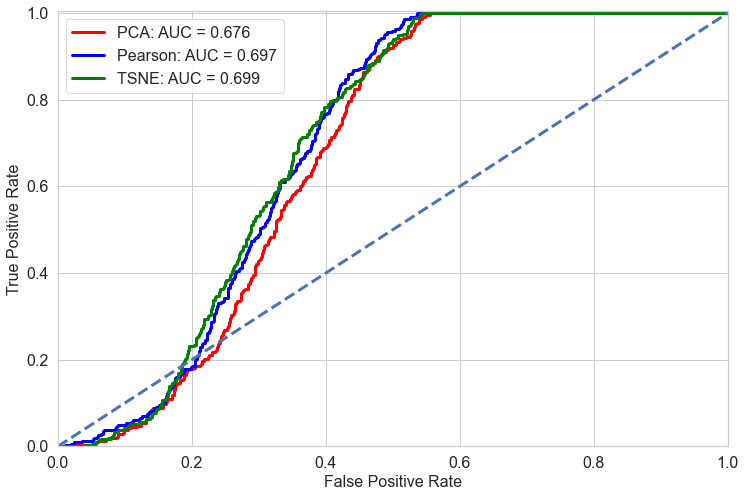

In [91]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot(fpr_pca, tpr_pca, label='PCA: AUC = {}'.format(np.round(roc_auc_score(y_true_pca, y_score_pca), 3)), c='red', lw=3)
ax.plot(fpr_pearson, tpr_pearson, label='Pearson: AUC = {}'.format(np.round(roc_auc_score(y_true_pearson, y_score_pearson), 3)), c='blue', lw=3)
ax.plot(fpr_tsne, tpr_tsne, label='TSNE: AUC = {}'.format(np.round(roc_auc_score(y_true_tsne, y_score_tsne), 3)), c='green', lw=3)

ax.plot([0, 1], [0, 1], '--', lw=3)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.grid(True)
ax.legend(loc='lower right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.xlim(0, 1)
plt.ylim(0, 1.004)
plt.savefig('roc.png', dpi=200, bbox_inches='tight')
plt.show()

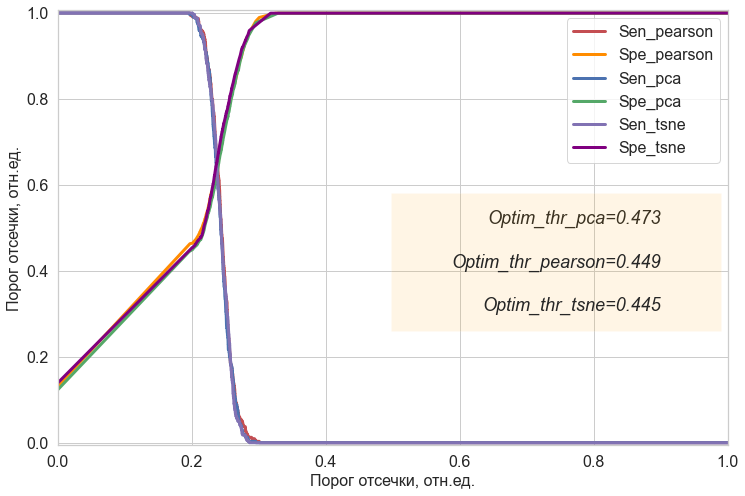

In [92]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot(thresholds_pearson, tpr_pearson, label='Sen_pearson', c='r', lw=3)
ax.plot(thresholds_pearson, 1 - fpr_pearson, label='Spe_pearson', c='darkorange', lw=3)
ax.plot(thresholds_pca, tpr_pca, label='Sen_pca', c='b', lw=3)
ax.plot(thresholds_pca, 1 - fpr_pca, label='Spe_pca', c='g', lw=3)
ax.plot(thresholds_tsne, tpr_tsne, label='Sen_tsne', c='m', lw=3)
ax.plot(thresholds_tsne, 1 - fpr_tsne, label='Spe_tsne',c='purple', lw=3)
ax.text(0.9, 0.5, 'Optim_thr_pca=' + str(get_optim_thr(tpr_pca, fpr_pca)), style='italic',
verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=18)
ax.text(0.9, 0.4, 'Optim_thr_pearson=' + str(get_optim_thr(tpr_pearson, fpr_pearson)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.1, 'pad': 60},
verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=18)
ax.text(0.9, 0.3, 'Optim_thr_tsne=' + str(get_optim_thr(tpr_tsne, fpr_tsne)), style='italic',
verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=18)
ax.set_xlabel('Порог отсечки, отн.ед.', fontsize=16)
ax.set_ylabel('Порог отсечки, отн.ед.', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.xlim(0, 1.0)
plt.ylim(-0.006, 1.006)
fig.savefig('spse.png', dpi=200, format='png')
plt.show()

# PCA

In [75]:
N_dupl = 50
noisy_spectra = spectra.copy().T
noisy_spectra['substance'] = noisy_spectra.index
noisy_spectra.reset_index(inplace=True, drop=True)
for i in range(N_dupl):
    for subst in titles:
        spectrum, SNR = np.array(spectra[subst]), 3
        amp = max(1 - spectrum)
        noisy_spectra = noisy_spectra.append(pd.Series(np.array(noised(spectrum, SNR, amp))), ignore_index=True)
        noisy_spectra.substance[noisy_spectra.shape[0] - 1] = subst

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [76]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = noisy_spectra.iloc[10:].copy()
X['substance'] = noisy_spectra['substance']
X.reset_index(inplace=True, drop=True)

X_rescaled = (X.drop(columns='substance'))

pca = PCA(n_components=3)
X_rescaled = sc.fit_transform(X_rescaled)
pca.fit(X_rescaled)
X_reduced = pca.transform(X_rescaled)
X_principal = pd.DataFrame(data = X_reduced, columns = ['principal component ' + str(i) for i in range(X_reduced.shape[1])])
spec_pca = pd.concat([X_principal, X[['substance']]], axis = 1)

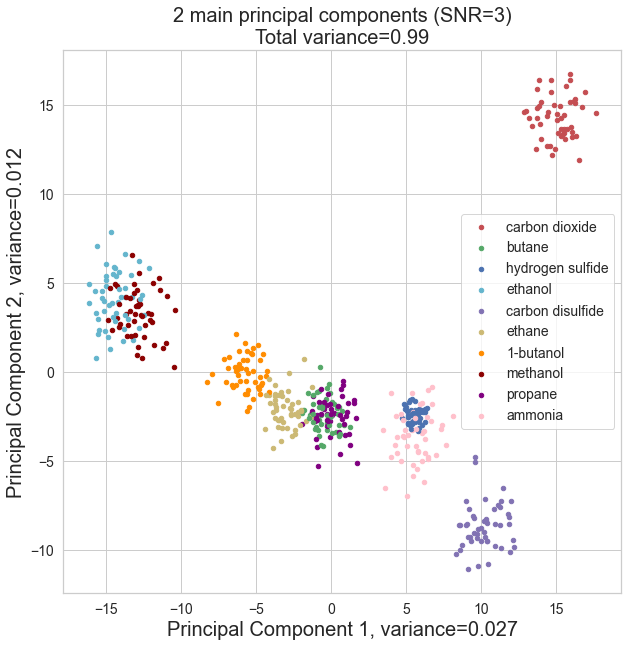

In [77]:
plt.figure(figsize = (10,10))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'darkred', 'purple', 'pink'] * N_dupl
for j in range(spec_pca.shape[0]):
        plt.scatter(spec_pca.iloc[j][0], spec_pca.iloc[j][1], c = colors[j], s = 20)
plt.xlabel('Principal Component 1, ' + 'variance=' + str(np.round(pca.explained_variance_ratio_[0], 3)), fontsize = 20)
plt.ylabel('Principal Component 2, ' + 'variance=' + str(np.round(pca.explained_variance_ratio_[1], 3)), fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.title('2 main principal components (SNR=3)\nTotal variance=0.99', fontsize = 20)
plt.legend(titles, fontsize = 14)
plt.savefig('pca2.png', dpi=200, bbox_inches='tight')
plt.show()

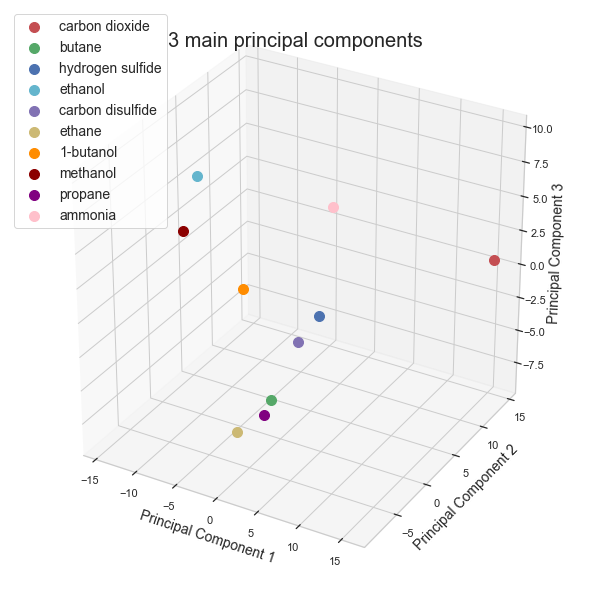

In [78]:
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)

ax.set_xlabel('Principal Component 1', fontsize = 14)
ax.set_ylabel('Principal Component 2', fontsize = 14)
ax.set_zlabel('Principal Component 3', fontsize = 14)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'darkred', 'purple', 'pink']
for i in range(len(titles)):
    ax.scatter(spec_pca.iloc[i][0], spec_pca.iloc[i][1], spec_pca.iloc[i][2], c = colors[i], s = 100, label=titles[i])
    
plt.grid(True)
plt.title('3 main principal components', fontsize=20)
plt.legend(fontsize=14, loc='upper left')
plt.savefig('pca3.png', dpi=200, bbox_inches='tight')
plt.show()

# TSNE

In [79]:
X = noisy_spectra.iloc[10:].copy()
X['substance'] = noisy_spectra['substance']
X.reset_index(inplace=True, drop=True)

X_rescaled = (X.drop(columns='substance'))

pca = PCA(n_components=3)
pca.fit(X_rescaled)
X_reduced = pca.transform(X_rescaled)
X_principal = pd.DataFrame(data = X_reduced, columns = ['principal component ' + str(i) for i in range(X_reduced.shape[1])])
spec_pca = pd.concat([X_principal, X[['substance']]], axis=1)

X = spec_pca.copy()
X['substance'] = spec_pca['substance']
X.reset_index(inplace=True, drop=True)

X_rescaled = (X.drop(columns='substance'))
tsne = TSNE(n_components=3, perplexity=15, learning_rate=10, init='pca', random_state=8)
X_reduced = tsne.fit_transform(np.array(X_rescaled))
X_principal = pd.DataFrame(data=X_reduced, columns=['principal component ' + str(i) for i in range(X_reduced.shape[1])])
spec_tsne = pd.concat([X_principal, X[['substance']]], axis = 1)

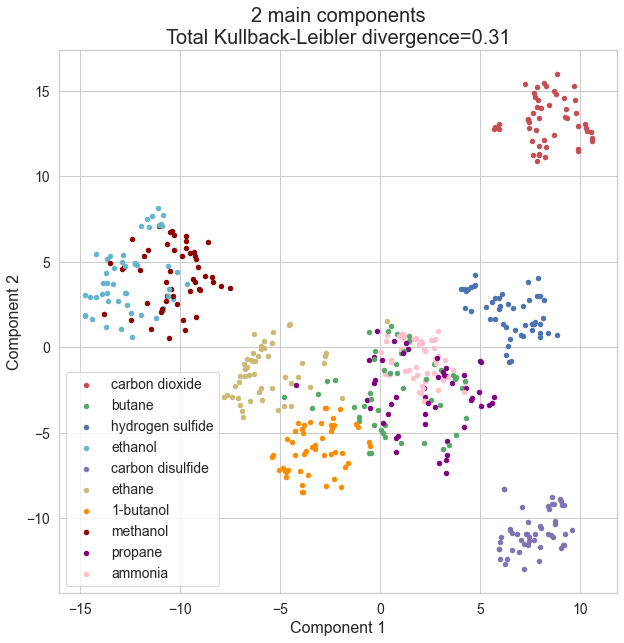

In [80]:
plt.figure(figsize = (10,10))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'darkred', 'purple', 'pink'] * 50
for j in range(spec_tsne.shape[0]):
        plt.scatter(spec_tsne.iloc[j][0], spec_tsne.iloc[j][1], c = colors[j], s = 20)
plt.xlabel('Component 1', fontsize = 16)
plt.ylabel('Component 2', fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.title('2 main components\n' + 'Total Kullback-Leibler divergence=' + str(np.round(tsne.kl_divergence_, 3)), fontsize = 20)
plt.legend(titles, fontsize=14)
plt.savefig('tsne2.png', dpi=200, bbox_inches='tight')
plt.show()

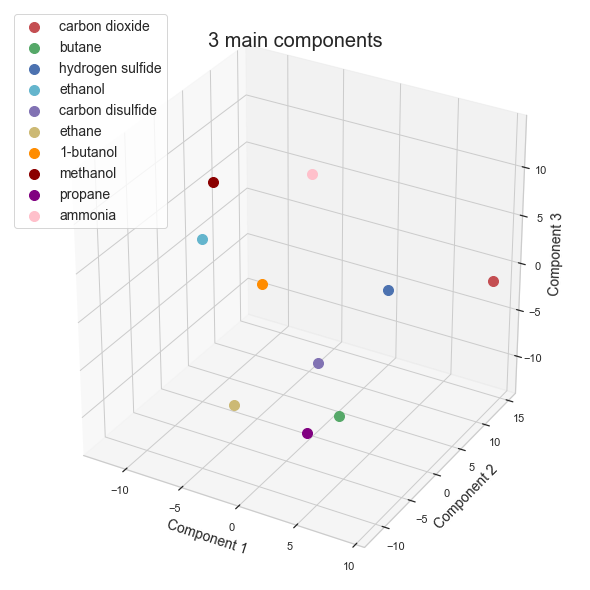

In [81]:
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)

ax.set_xlabel('Component 1', fontsize = 14)
ax.set_ylabel('Component 2', fontsize = 14)
ax.set_zlabel('Component 3', fontsize = 14)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'darkorange', 'darkred', 'purple', 'pink']

for i in range(len(titles)):
    ax.scatter(spec_tsne.iloc[i][0], spec_tsne.iloc[i][1], spec_tsne.iloc[i][2], c = colors[i], s = 100, label=titles[i])
    
plt.grid(True)
plt.title('3 main components', fontsize=20)
plt.legend(fontsize=14, loc='upper left')
plt.savefig('tsne3.png', dpi=200, bbox_inches='tight')
plt.show()